In [8]:
import xarray as xr
from utils import geo
import numpy as np
import matplotlib.pyplot as plt

### Chlorophyll and Primary production

In [9]:
rootdir = '/local/data/globcolour/from_cmems/OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082/SouthernOcean_30Sto65S/monthly/'
dataset = 'chl'
filename = '*'+dataset+'*.nc'
ds = xr.open_mfdataset(rootdir+filename).chunk({'time':1})
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

In [10]:
if dataset=='chl':
    variable = 'CHL'
elif dataset== 'pp':
    variable = 'PP'

In [11]:
# Extract spatial average for each year
years = np.arange(1998,2022)
# Ordering such that years run from July to June
months = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
months_norm = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ds_year = xr.DataArray(dims=['month','year'],coords={'year':years,'month':months})
for i,year in enumerate(years):
    print(year)
    # Need to set nans to zero otherwise it ignores them in the average!
    x = (ds[variable].sel({'time':slice(str(year-1)+'-07-01',str(year)+'-06-30')})).fillna(0).weighted(ds['area'].fillna(0)).sum(['lat','lon'])
    # Determine which months are present
    presentmonths = [months_norm[i] for i in x['time.month'].values-1]
    # Put into dataset
    ds_year.loc[{'year':year,'month':presentmonths}]=x.values

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


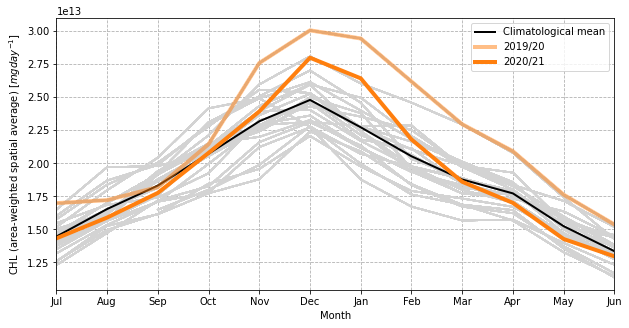

In [19]:
fig,ax = plt.subplots(figsize=(10,5))
# ds_year = ds_year.roll(month=6,roll_coords=True)
# All years
for year in years[:-1]:
    ax.plot(ds_year['month'],ds_year,color='lightgray')
# Climatology
ds_clim = ds_year.mean('year')
ax.plot(ds_year['month'],ds_clim,color='black',linewidth=2,label='Climatological mean')
# 2020
ax.plot(ds_year['month'],ds_year.isel(year=-2),color='tab:orange',alpha=0.5,linewidth=4,label='2019/20')
# 2021
ax.plot(ds_year['month'],ds_year.isel(year=-1),color='tab:orange',linewidth=4,label='2020/21')
# Labels
ax.set_xlabel('Month')
ax.set_ylabel(variable+' (area-weighted spatial average) [$mg day^{-1}$]')
ax.set_xlim(['Jul','Jun'])
ax.grid(linestyle='--')
ax.legend()
fig.savefig('../../figures/seasonal-climatology_globcolour-monthly_'+variable+'.png',dpi=300,transparent=True)

### Phytoplankton functional type

In [29]:
rootdir = '/local/data/globcolour/from_cmems/pp/'
dataset = 'pft'
filename = '*'+dataset+'*.nc'
ds = xr.open_mfdataset(rootdir+filename).chunk({'time':1})
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

In [37]:
# Extract spatial average for each year
years = np.arange(2003,2022)
# Ordering such that years run from July to June
months = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
months_norm = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ds_year = xr.Dataset()
for variable in ds.drop(['dxG','dyG','dxC','dyC','area']).data_vars:
    if variable[-5:]=="error":
        continue
    print(variable)
    ds_year[variable] = xr.DataArray(dims=['month','year'],coords={'year':years,'month':months})
    for i,year in enumerate(years):
    #     print(year)
        # Need to set nans to zero otherwise it ignores them in the average!
        x = (ds[variable].sel({'time':slice(str(year-1)+'-07-01',str(year)+'-06-30')})).fillna(0).weighted(ds['area'].fillna(0)).sum(['lat','lon'])
        # Determine which months are present
        presentmonths = [months_norm[i] for i in x['time.month'].values-1]
        # Put into dataset
        ds_year[variable].loc[{'year':year,'month':presentmonths}]=x.values
ds_year.to_netcdf('../../data/'+dataset+'_annual.nc')

DIATO
DINO
GREEN
NANO
PICO
PROCHLO
PROKAR


In [38]:
ds_year = xr.open_dataset('../../data/'+dataset+'_annual.nc')

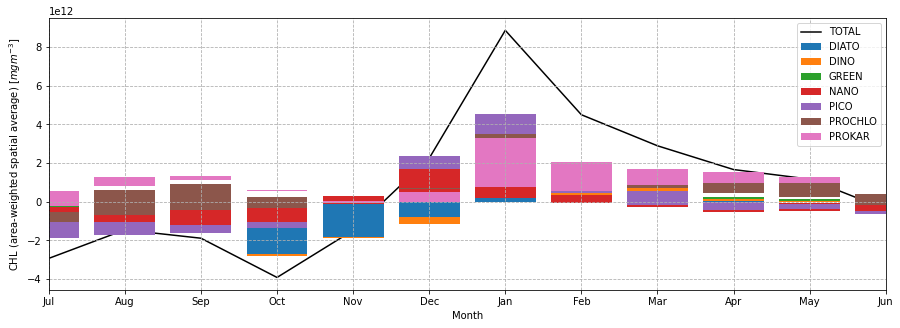

In [51]:
ds_clim = ds_year.mean('year')
ds_anom = ds_year - ds_clim
total = xr.zeros_like(ds_anom['DIATO'].isel(year=-1))
fig,ax = plt.subplots(figsize=(15,5))
for i,variable in enumerate(ds_anom.data_vars):
    total += ds_anom[variable].isel(year=-1)
    now = ds_anom[variable].isel(year=-1)
    if i==0:
        last=0
    ax.bar(ds_anom['month'],now,bottom=last,label=variable)
    last = now.copy()
ax.plot(total['month'],total,color='k',label='TOTAL',zorder=0)
ax.set_xlabel('Month')
ax.set_ylabel('CHL (area-weighted spatial average) [$mg m^{-3}$]')
ax.set_xlim(['Jul','Jun'])
ax.grid(linestyle='--')
ax.legend()

In [52]:
now

<xarray.DataArray 'PROKAR' (month: 12)>
array([-7.72827354e+11, -4.44414006e+11, -2.00054987e+11, -6.80152062e+10,
        8.95168365e+10,  5.48369279e+11,  2.54650029e+12,  1.48282412e+12,
        8.47334218e+11,  5.41684235e+11,  3.44931338e+11, -3.23968041e+10])
Coordinates:
    year     int64 2021
  * month    (month) object 'Jul' 'Aug' 'Sep' 'Oct' ... 'Mar' 'Apr' 'May' 'Jun'